In [14]:
import sys
import spacy
from collections import deque, OrderedDict
from tqdm import tqdm
import itertools as it
from random import random
from tabulate import tabulate
import matplotlib
# import matplotlib.pyplot as plt
%matplotlib inline
plt = matplotlib.pyplot

In [5]:
LANG = 'de'
BATCH_SIZE = 10000
N_THREADS = 4

MAX_LEVEL = 2

sentence = "Ist der neue Fernseher, den ich gestern bestellt habe, schon angekommen?"

In [6]:
nlp = spacy.load(LANG, vectors=False)

In [7]:
from nltk import Tree

def nodestring(node):
    return node.orth_ + '_' + node.pos_

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(nodestring(node), [to_nltk_tree(child) for child in node.children])
    else:
        return nodestring(node)
    
def print_tree(doc):
    for sent in doc.sents:
        to_nltk_tree(sent.root).pretty_print()

In [33]:
def hmean(*values):
    return len(values) / sum(1 / x for x in values)

pos_high_p = set(['VERB', 'NOUN'])
pos_middle_p = set(['ADV', 'PPER', 'ADJ'])

def pos_p(pos):
    if pos in pos_high_p:
        return 0.8
    elif pos in pos_middle_p:
        return 0.6
    else:
        return 0.4
    
def should_sample(word, level, debug):
    level_prob = 1 / level
    pos_prob = level_prob
    prob = hmean(level_prob, pos_prob)
    if debug:
        return word.text, prob
    else:
        return random() < prob

def sample_context(word, debug):
    candidates = deque()
    seen = set([word])

    def add_to_queue(word, level):
        for w in it.chain(word.children, [word.head]):
            if not w in seen:
                seen.add(w)
                candidates.append((level, w))

    add_to_queue(word, 1)
    while candidates:
        level, candidate = candidates.popleft()
        if debug:
            yield should_sample(candidate, level, debug=True)
        else:
            if should_sample(candidate, level, debug=False):
                yield candidate
        if level < MAX_LEVEL:
            add_to_queue(candidate, level + 1)

def doc2pairs(doc, debug=False):
    print_tree(doc)
    if not debug:
        for word in doc:
            for ctx in sample_context(word, debug):
                yield (word.text, ctx.text)
    else:
        for word in doc:
            yield (word.text, list(sample_context(word, debug)))
            
def print_sent_probs(sentence, word):
    doc = nlp(sentence)
    probs = list(doc2pairs(doc, debug=True))
    prob_dict = dict((word, dict(ps))for word, ps in probs)
    word_probs = prob_dict[word]
    words = [word.text for word in doc]
    probs = [word_probs[word] if word in word_probs else 0 for word in words]
    prob_strings = ["{:.2f}".format(p) for p in probs]
    print(tabulate([words, prob_strings]))
    D = OrderedDict(reversed(list(zip(words, probs))))
    plt.barh(range(len(D)), D.values(), align='center')
    plt.yticks(range(len(D)), list(D.keys()))
    plt.show()
    
def print_pairs(sentence):
    doc = nlp(sentence)
    pairs = doc2pairs(doc, debug=False)
    for word, ctx in pairs:
        print(word, ctx)
        

In [34]:
print_pairs(sentence)

                                    Ist_AUX                                                                
    ___________________________________|___________________________________________________________         
   |       |                     Fernseher_NOUN                                                    |       
   |       |        ___________________|____________________                                       |        
   |       |       |       |           |                 habe_AUX                                  |       
   |       |       |       |           |            ________|___________                           |        
   |       |       |       |           |           |              bestellt_VERB             angekommen_VERB
   |       |       |       |           |           |         ___________|____________              |        
,_PUNCT ?_PUNCT der_DET neue_ADJ    ,_PUNCT     ich_PRON den_PRON               gestern_ADV    schon_ADV   

Ist Fernseher
Ist ,
Ist

Ist der neue Fernseher, den ich gestern bestellt habe, schon angekommen?
                                    Ist_AUX                                                                
    ___________________________________|___________________________________________________________         
   |       |                     Fernseher_NOUN                                                    |       
   |       |        ___________________|____________________                                       |        
   |       |       |       |           |                 habe_AUX                                  |       
   |       |       |       |           |            ________|___________                           |        
   |       |       |       |           |           |              bestellt_VERB             angekommen_VERB
   |       |       |       |           |           |         ___________|____________              |        
,_PUNCT ?_PUNCT der_DET neue_ADJ    ,_PUNCT     ich_PRON de

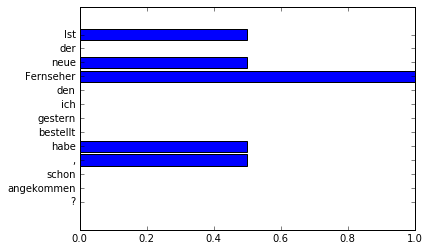

In [35]:
print(sentence)
print_sent_probs(sentence, 'der')